# Непрерывные переменные

В отличие от пропорций, у непрерывных переменных нам не известен тип распределения, а значит и неизвестно как именно нужно расчитывать размер выборки

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
from tqdm.notebook import tqdm
from scipy.stats import ttest_ind, norm


ayu_colors = {
    "axes.facecolor": "#1F2430",  # фон графика
    "figure.facecolor": "#1F2430",  # фон фигуры
    "text.color": "#CBCCC6",  # цвет текста
    "axes.labelcolor": "#CBCCC6",  # цвет подписей осей
    "xtick.color": "#707A8C",  # цвет делений оси X
    "ytick.color": "#707A8C",  # цвет делений оси Y
    "grid.color": "#232834",  # цвет сетки
    "axes.prop_cycle": plt.cycler(
        color=["#8dd3c7", "#feffb3", "#bfbbd9", "#fa8174", "#81b1d2"]
    ),  # цвета линий как в dark_background
}

plt.rcParams.update(ayu_colors)

## Нормальное распределение и применение t-test:

<Axes: >

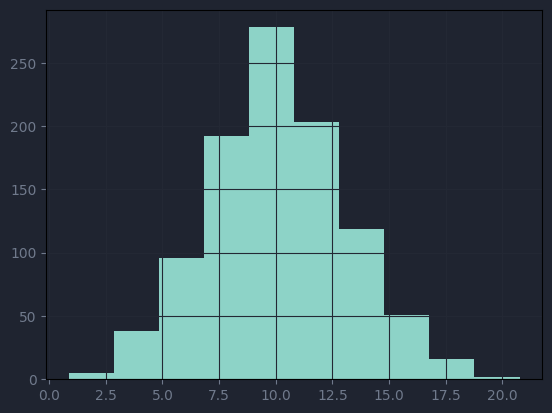

In [9]:
pd.Series(np.random.normal(10, 3, size=1000)).hist()

<Axes: >

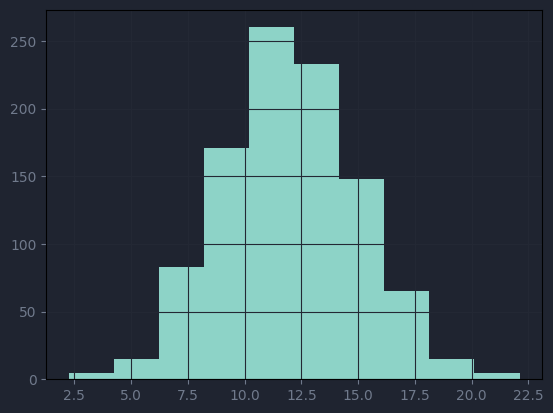

In [7]:
pd.Series(np.random.normal(12, 3, size=1000)).hist()

In [20]:
baseline = 10
mde = 2
result = []
n = 1000
sample_size = 36

for _ in range(n):
    a = np.random.normal(baseline, 3, size=sample_size)
    b = np.random.normal(baseline + mde, 3, size=sample_size)
    _, pval = ttest_ind(a, b, equal_var=False)
    result.append(pval)

t = pd.Series(result)

In [21]:
(t < 0.05).mean()

np.float64(0.794)

Как проверить, что можно применять t test для наших данных:
- Выборочное среднее распределено нормально - bootstrap + qq plot
- p-value для выборок из одного распределения(aa test) имеет равномерное распределение(uniform) - bootstrap + qq plot
- теоретичесмкий false positive == практическому false positive

### 1. Выборочное среднее распределено нормально - bootstrap + qq plot:

<Axes: >

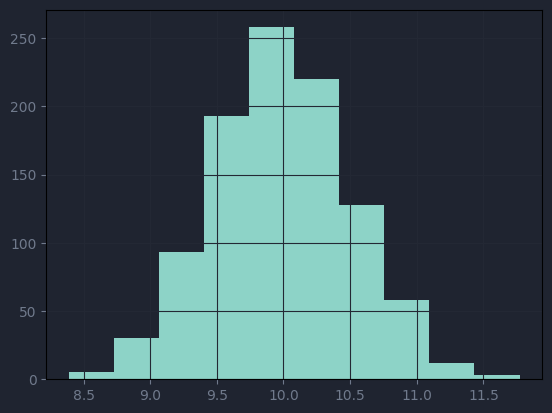

In [30]:
t = pd.Series([np.random.normal(10, 3, size=36).mean() for _ in range(1000)])
t.hist()

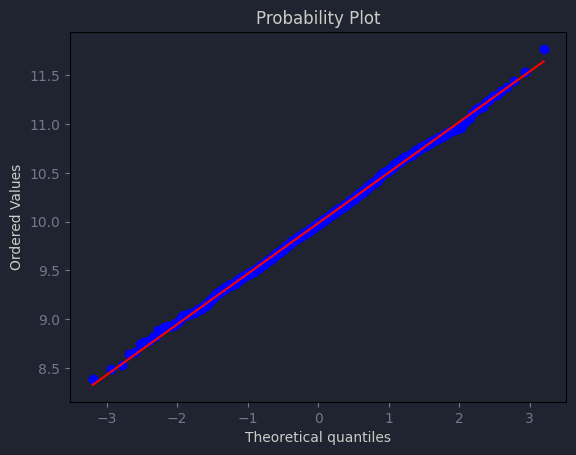

In [ ]:
stats.probplot(t, dist="norm", plot=pylab)
pylab.show()

### 2. p-value для выборок из одного распределения(aa test) имеет равномерное распределение(uniform) - bootstrap + qq plot

In [32]:
baseline = 10
result = []
n = 1000
sample_size = 36

for _ in range(n):
    a = np.random.normal(baseline, 3, size=sample_size)
    a1 = np.random.normal(baseline, 3, size=sample_size)
    _, pval = ttest_ind(a, a1, equal_var=False)
    result.append(pval)

t = pd.Series(result)

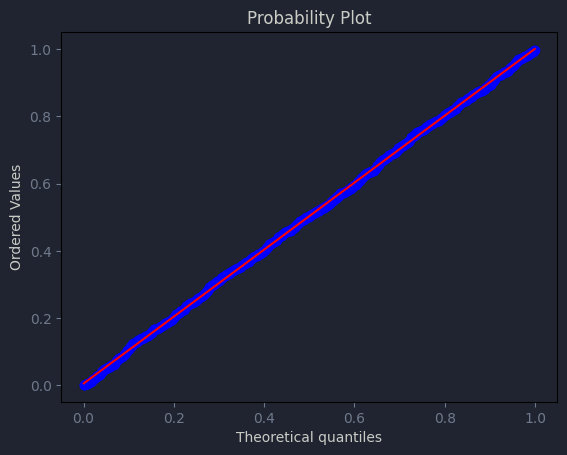

In [35]:
stats.probplot(t, dist="uniform", plot=pylab)
pylab.show()

### 3. Теоретичесмкий false positive == практическому false positive:

In [36]:
(t < 0.05).mean()

np.float64(0.051)

### Расчет мощности для t-теста

У нас есть только выборка. Для того, чтобы расчитать eefect_size для формулы, необходимо узнать mde и std для нашей выборки:

In [53]:
std = float(pd.Series(np.random.normal(baseline, 3, size=1000)).std())

параметр effect_size - standardized effect size, difference between the two means divided by the standart deviation. Must be positive number

In [54]:
import statsmodels.stats.api as sms

effect_size = (12 - 10) / std

sms.TTestIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1)

36.17197270811547

## Ненормальное распределение:

В случае ненормального распределения, применение t-test будет нецелесообразным, поскольку распределение средних будет смещенным, например для логнормального распределения

In [ ]:
a = np.random.lognormal(mean=5, sigma=2, size=(100000,))
b = np.random.lognormal(mean=5.04, sigma=2, size=(100000,))

<Axes: >

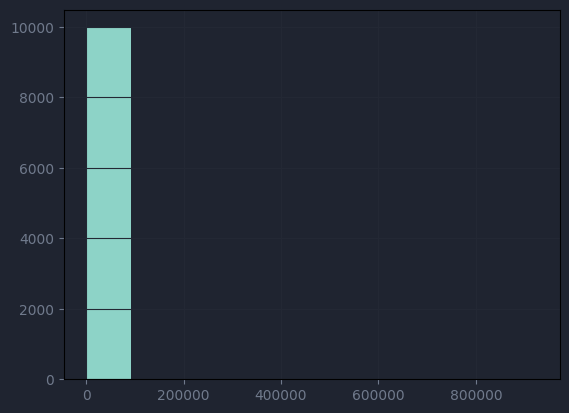

In [58]:
pd.Series(a).hist()

In [60]:
t = pd.Series(
    [
        np.random.lognormal(mean=5, sigma=2, size=(100000,)).mean()
        for _ in tqdm(range(1000))
    ]
)

  0%|          | 0/1000 [00:00<?, ?it/s]

<Axes: >

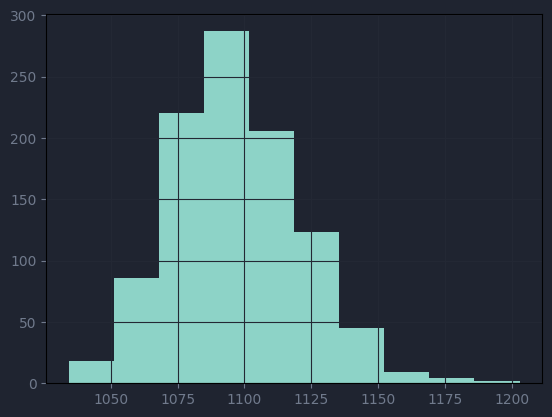

In [61]:
t.hist()

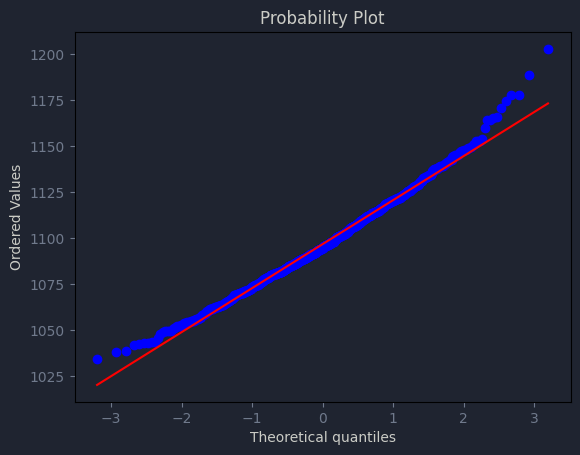

In [62]:
stats.probplot(t, dist="norm", plot=pylab)
pylab.show()

В данном случае критерий для проведения t-test уже нарушается, поскольку средние распределены ненормально

In [71]:
result = []
n = 1000

for _ in tqdm(range(n)):
    a = np.random.lognormal(mean=5, sigma=2, size=(100000,))
    a1 = np.random.lognormal(mean=5, sigma=2, size=(100000,))
    _, pval = ttest_ind(a, a1, equal_var=False)
    result.append(pval)

t = pd.Series(result)

  0%|          | 0/1000 [00:00<?, ?it/s]

<Axes: >

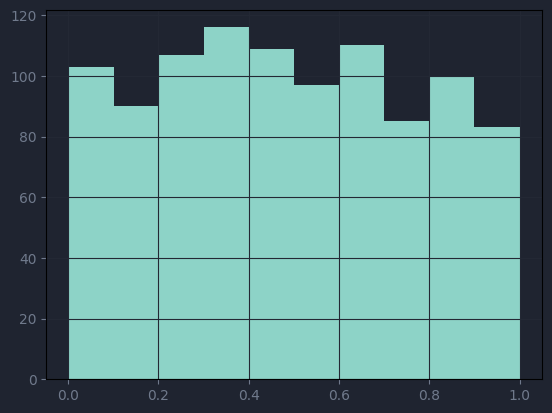

In [72]:
t.hist()

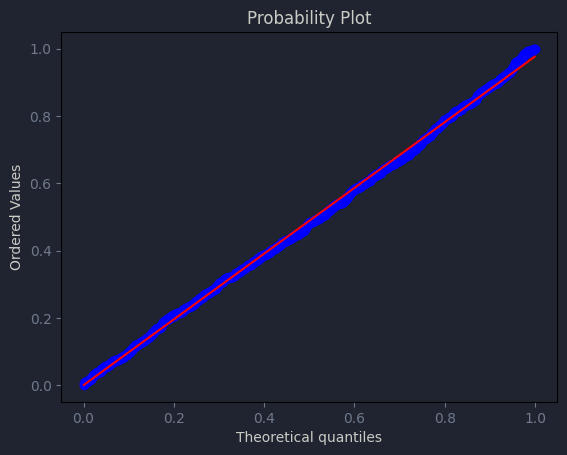

In [73]:
stats.probplot(t, dist="uniform", plot=pylab)
pylab.show()

In [74]:
(t < 0.05).mean()

np.float64(0.044)

Кажется, что t-test можно проводить, но посмотрим на мощность теста:

In [75]:
result = []
n = 1000

for _ in tqdm(range(n)):
    a = np.random.lognormal(mean=5, sigma=2, size=(100000,))
    b = np.random.lognormal(mean=5.04, sigma=2, size=(100000,))
    _, pval = ttest_ind(a, b, equal_var=False)
    result.append(pval)

t = pd.Series(result)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [78]:
print(
    f"Мощность t-test'a для логнормального распределения равна {(t < 0.05).mean():0.3f}"
)

Мощность t-test'a для логнормального распределения равна 0.269


Для проведения этого теста необходимо набирать большую выборку. Попробуем расчитать размер выборки для проведения t-test'a при логнормальном распределении. Прикинем среднее для выборок с помощью bootstrap:

In [89]:
a_mean_bs = pd.Series(
    [
        np.random.lognormal(mean=5, sigma=2, size=(100000,)).mean()
        for _ in tqdm(range(1000))
    ]
).mean()
a_mean_bs

  0%|          | 0/1000 [00:00<?, ?it/s]

np.float64(1096.9213429560227)

In [90]:
b_mean_bs = pd.Series(
    [
        np.random.lognormal(mean=5.04, sigma=2, size=(100000,)).mean()
        for _ in tqdm(range(1000))
    ]
).mean()
b_mean_bs

  0%|          | 0/1000 [00:00<?, ?it/s]

np.float64(1142.2620036296346)

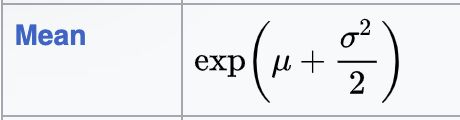

In [93]:
a_mean_teor = np.exp(5 + pow(2, 2) / 2)
b_mean_teor = np.exp(5.04 + pow(2, 2) / 2)
print(a_mean_teor, b_mean_teor)

1096.6331584284585 1141.387606628968


In [97]:
effect_size = (b_mean_teor - a_mean_teor) / a.std()

sms.TTestIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1)

416980.7309088814

In [98]:
t = pd.Series(
    [
        np.random.lognormal(mean=5, sigma=2, size=(416981,)).mean()
        for _ in tqdm(range(1000))
    ]
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [101]:
result = []
n = 1000

for _ in tqdm(range(n)):
    a = np.random.lognormal(mean=5, sigma=2, size=(416981,))
    b = np.random.lognormal(mean=5.04, sigma=2, size=(416981,))
    _, pval = ttest_ind(a, b, equal_var=False)
    result.append(pval)

t = pd.Series(result)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [102]:
print(
    f"Мощность t-test'a для логнормального распределения равна {(t < 0.05).mean():0.3f}"
)

Мощность t-test'a для логнормального распределения равна 0.739
